# Linear Regression Practice

In [496]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoLarsCV, Ridge

1. Reading Data

In [527]:
data_train = pd.read_csv('train.csv', index_col=0)
data_test = pd.read_csv('test.csv', index_col=0)
data = pd.concat([data_train,data_test],sort = True)
data.shape

(2919, 80)

In [528]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


2. Visualizing Data

In [529]:
%matplotlib inline

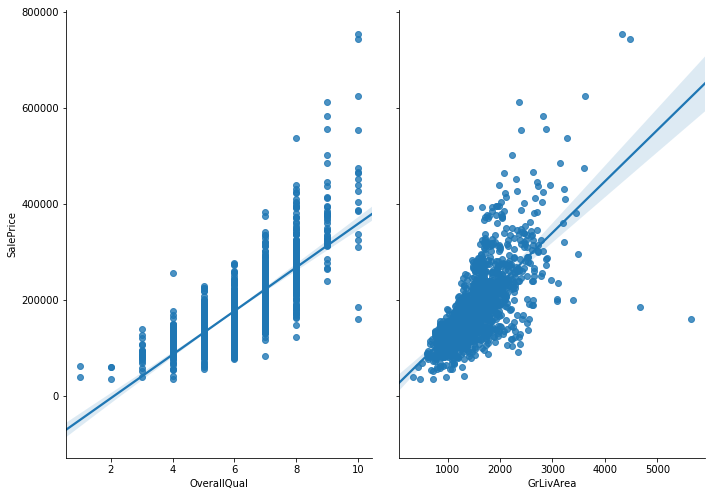

In [530]:
sns.pairplot(data, x_vars=['OverallQual', 'GrLivArea'], y_vars='SalePrice', height=7, aspect=0.7, kind='reg')

3. Checking correlation

In [531]:
traincorr = data.corr()['SalePrice']
traincorr = pd.DataFrame(traincorr)
traincorr.columns = ["Corr"]
traincorr_ordered = traincorr.sort_values(by=['Corr'],ascending=False)
traincorr_ordered.head(20)

,Corr
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


4. Checking mising data

In [532]:
countmissing = data.isnull().sum().sort_values(ascending=False)
percentmissing = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
data_miss = pd.concat([countmissing,percentmissing], axis=1)
data_miss.columns = ["count","%"]
count = data_miss['count'] > 0
data_miss[count]

,count,%
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


4. Filling missing data

In [533]:
data['Electrical'] = data.Electrical.fillna("SBrkr")
data['MasVnrType'] = data.MasVnrType.fillna("None")

In [534]:
data['MasVnrArea']= data.MasVnrArea.fillna(data.MasVnrArea.mean())

In [535]:
data.GarageYrBlt.fillna(data.YearBuilt, inplace=True)

In [536]:
data['LotFrontage']= data.LotFrontage.fillna(data.LotArea)
data['LotFrontage']= data['LotFrontage'].astype(int)

5. Creating new features based on more correlated ones

In [537]:
# Total Living Area
Livingtotalsf = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GarageArea'] + data['WoodDeckSF'] + data['OpenPorchSF']
data['LivingTotalAreaSF'] = Livingtotalsf

# Total Living Area percentage
data['PercentSQtoLot'] = data['LivingTotalAreaSF'] / data['LotArea']

# Total amount of bathrooms withing the building, including full and half
data['TotalBaths'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['HalfBath'] + data['FullBath']

# Percentage of total rooms are bedrooms
data['PercentBedrmtoRooms'] = data['BedroomAbvGr'] / data['TotRmsAbvGrd']

# Time since last remodel in years
data['YearsSinceRemodel'] = 2018 - ((data['YearRemodAdd'] - data['YearBuilt']) + data['YearBuilt'])

In [538]:
traincorr = data.corr()['SalePrice']
traincorr = pd.DataFrame(traincorr)
traincorr.columns = ["Corr"]
traincorr_ordered = traincorr.sort_values(by=['Corr'],ascending=False)
traincorr_ordered.head(30)

,Corr
SalePrice,1.000000
LivingTotalAreaSF,0.815688
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
TotalBaths,0.613005
1stFlrSF,0.605852
FullBath,0.560664


6. Selecting final features

In [539]:
price = data['SalePrice']

neigh = data[['Neighborhood','MSZoning','MSSubClass','BldgType','HouseStyle']]

dates = data[['YearBuilt','YearRemodAdd','GarageYrBlt','YearsSinceRemodel']]

quacon = data[['ExterQual','BsmtQual','PoolQC','Condition1','Condition2','SaleCondition',
                  'BsmtCond','ExterCond','GarageCond','KitchenQual','GarageQual','HeatingQC','OverallQual','OverallCond']]

features =  data[['Foundation','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                     'MiscFeature','PavedDrive','Utilities',
                     'Heating','CentralAir','Electrical','Fence']]

sqfoot = data[['LivingTotalAreaSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea',
                  'GarageArea','WoodDeckSF','OpenPorchSF','LotArea','PercentSQtoLot','LowQualFinSF']]

roomfeatcount = data[['PercentBedrmtoRooms','TotalBaths','FullBath','HalfBath',
                         'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','EnclosedPorch']]


In [540]:
X = pd.concat([neigh,dates,quacon,features,sqfoot,roomfeatcount], axis=1)

In [541]:
X.shape

(2919, 55)

In [542]:
data = pd.get_dummies(data)

In [543]:
data.shape

(2919, 294)

7. Setting final data (train/test)

In [544]:
train_X = data[data['SalePrice'].notnull()]
del train_X['SalePrice']
test_X =  data[data['SalePrice'].isnull()]
del test_X['SalePrice']

In [545]:
X = train_X
X.shape

(1460, 293)

In [552]:
y = price[price.notnull()]
y.shape

(1460,)

In [553]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [554]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1095, 293)
(365, 293)
(1095,)
(365,)


8. Linear Regression

In [555]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoLarsCV, Ridge

linreg = LinearRegression()

linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [556]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

3.93463183814e+13
[ -8.22806393e+06  -8.22805247e+06   1.42915890e+01  -1.31749046e+04
   4.11465735e+11   4.11465735e+11  -8.20866985e+10  -8.20866969e+10
   4.11465735e+11   1.58054209e+01   4.19294232e+03  -8.20866956e+10
  -9.35995653e+10   1.39395910e+03  -1.05716612e+02  -9.35913372e+10
  -8.20866950e+10  -1.52952063e+04   5.91472033e-01   4.24740713e-02
   9.35913372e+10   2.86580786e+01   1.35669036e+01   4.54753739e+00
  -4.15452603e+02  -9.35995653e+10   5.32845927e+03   5.43766875e+03
   2.23141817e+02   3.60502972e+01   6.28458014e+03  -5.05065300e+11
  -9.35995653e+10   3.09605438e+02  -1.94981378e+10  -5.26112549e+02
   9.35995653e+10  -3.00583628e+04   8.20866986e+10   7.46129606e+04
  -1.94981380e+10   1.73261314e+03   9.87980919e+03  -2.72817571e+08
  -2.72830729e+08  -2.72828858e+08  -2.72830120e+08  -2.72835403e+08
   1.75744074e+08   1.75742960e+08  -6.26464766e+07   1.75746764e+08
   1.47230437e+04   3.14118796e+04   1.09106030e+04   9.92620433e+03
  -7.48120169e+0

8. Predicting

In [557]:
y_pred = linreg.predict(X_test)

9. Cheking RMSE

In [558]:
y_test.shape, y_pred.shape

((365,), (365,))

In [559]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

23823494.7996


10. Predicting for test data

In [523]:
test_input = pd.read_csv('test.csv')
test_input.shape

(1459, 80)

In [524]:
test_input.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
id = test_input['Id']
test_result = linreg.predict(test_input)

output = pd.DataFrame( { 'id': id , 'SalePrice': test_result} )
output = output[['id', 'SalePrice']]

output.to_csv("test_result.csv", index = False)

10. Referencces

https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a
https://towardsdatascience.com/house-prices-and-regressions-7adf696053d6